Explore in more detail the results of the best Linear SVM classifier trained on features extracted from a pre-trained CNN.

Specifically, the best result came from VGG Net (https://gist.github.com/ksimonyan/fd8800eeb36e276cd6f9#file-readme-md), with features extracted from Fully Connected Layer 7.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import caffe
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os, sys
import pickle
import sklearn.metrics as metrics
sys.path.append('../')
import helpers.histogram_classifier as hc
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
from IPython.core.display import HTML
css = open('styles/table-style.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
classes = pd.read_csv('../data/food-101/meta/top_classes.csv', index_col=0)
class_list = list(classes['class'].unique())

In [4]:
predictions = np.load("../transfer-learning/models/svm_vggnet/svm_vggnet_layer_7_2016_08_17/predicted_labels")
actuals = np.load("../transfer-learning/models/svm_vggnet/svm_vggnet_layer_7_2016_08_17/test_labels")
predictions = np.array([x.decode() for x in predictions])
actuals = np.array([x.decode() for x in actuals])
score, metrics, confusion = hc.get_metrics(actuals, predictions, class_list)

In [5]:
score

,Accuracy,F1,Precision,Recall
Results,0.685,0.684,0.684,0.685


In [6]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.55,0.51,0.53,211.0
lasagna,0.67,0.61,0.64,187.0
french_toast,0.64,0.62,0.63,208.0
guacamole,0.90,0.89,0.90,189.0
apple_pie,0.55,0.60,0.57,194.0
cheesecake,0.70,0.67,0.68,206.0
hamburger,0.71,0.76,0.73,200.0
fried_rice,0.81,0.88,0.84,213.0
carrot_cake,0.66,0.65,0.66,205.0
chocolate_cake,0.70,0.76,0.73,178.0


In [7]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,108,16,11,0,5,1,4,8,4,3,49,2
lasagna,10,114,10,1,12,3,5,5,4,1,9,13
french_toast,9,3,129,4,18,14,7,1,5,6,7,5
guacamole,0,0,0,169,4,0,6,5,1,2,1,1
apple_pie,5,6,12,2,117,11,11,3,11,5,7,4
cheesecake,3,3,8,0,15,137,2,2,14,17,3,2
hamburger,4,3,9,3,10,4,151,0,4,4,7,1
fried_rice,5,2,2,2,4,0,2,188,4,0,2,2
carrot_cake,3,5,5,2,16,11,4,9,134,12,4,0
chocolate_cake,0,2,2,1,5,11,3,0,16,135,3,0


Look at confusion matrix as a heatmap:

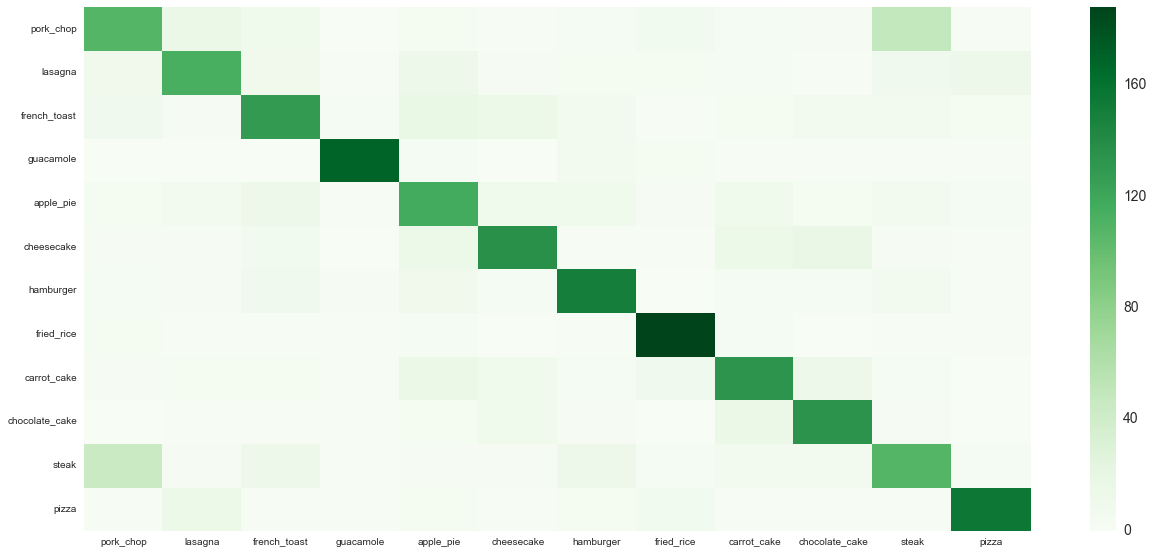

In [8]:
fig, ax = plt.subplots(figsize=(18,8))
sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, cmap='Greens')
fig.tight_layout()
plt.savefig('../reports/images/charts/cnn_feats_confusion.pdf', format='pdf', dpi=1200)

The most obvious fail cases are Steak & Pork chop being confused, and chocolate cake and cheesecake being confused
(slightly unsurprisingly)

In [9]:
labels = np.load("../transfer-learning/models/svm_vggnet/vggnet_test_images")
labels = np.array([x.decode() for x in labels])

In [10]:
# Group test image labels along with true and predicted class
test_images = []
for label, tru, predicted in zip(labels, actuals, predictions):
    d = {}
    d['label'] = label
    d['true_class'] = tru
    d['predicted_class'] = predicted
    test_images.append(d)

In [11]:
df = pd.DataFrame(test_images)

In [12]:
df.head(10)

,label,predicted_class,true_class
0,fried_rice/1941850.jpg,fried_rice,fried_rice
1,cheesecake/3834149.jpg,cheesecake,cheesecake
2,apple_pie/3897758.jpg,apple_pie,apple_pie
3,pizza/1655630.jpg,pizza,pizza
4,fried_rice/453052.jpg,fried_rice,fried_rice
5,french_toast/845721.jpg,french_toast,french_toast
6,cheesecake/621396.jpg,cheesecake,cheesecake
7,pork_chop/1059919.jpg,pork_chop,pork_chop
8,pizza/2035248.jpg,pizza,pizza
9,cheesecake/1639844.jpg,cheesecake,cheesecake


***Steaks predicted as Pork Chop:***

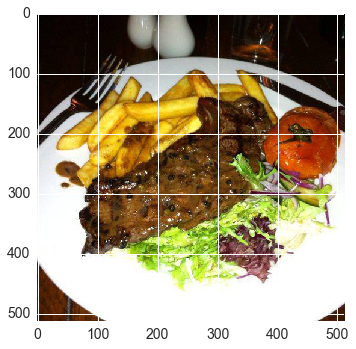

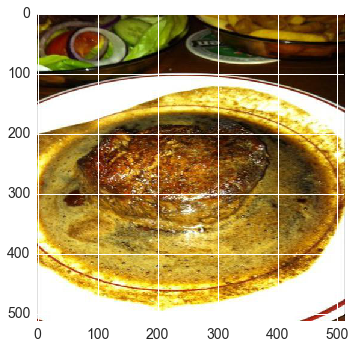

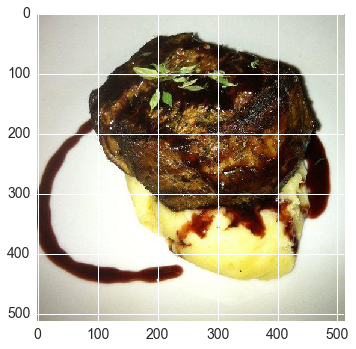

In [13]:
images = list(df[(df['predicted_class'] == 'pork_chop') & (df['true_class'] == 'steak')]['label'])
np.random.shuffle(images)
for im in images[:3]:
    image = caffe.io.load_image(os.path.join("../data/food-101/top_classes", im))
    plt.imshow(image)
    plt.show()

***Pork chop predicted as Steak:***

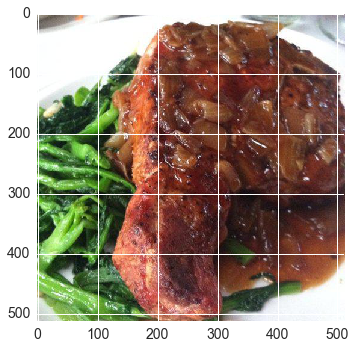

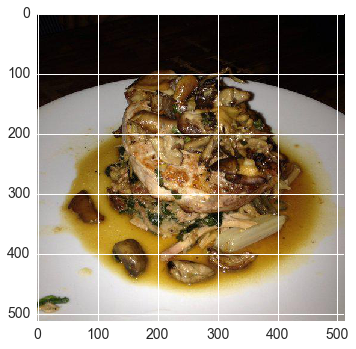

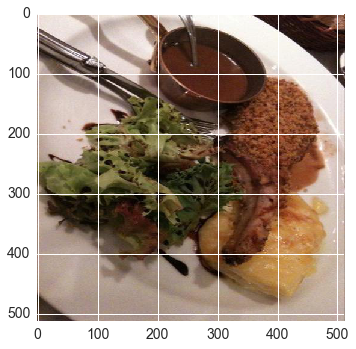

In [14]:
images = list(df[(df['predicted_class'] == 'steak') & (df['true_class'] == 'pork_chop')]['label'])
np.random.shuffle(images)
for im in images[:3]:
    image = caffe.io.load_image(os.path.join("../data/food-101/top_classes", im))
    plt.imshow(image)
    plt.show()

***Cheesecake predicted as chocolate cake:***

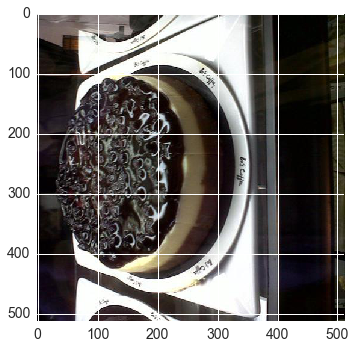

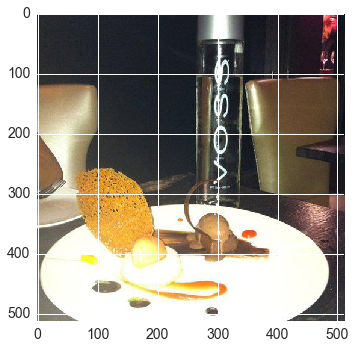

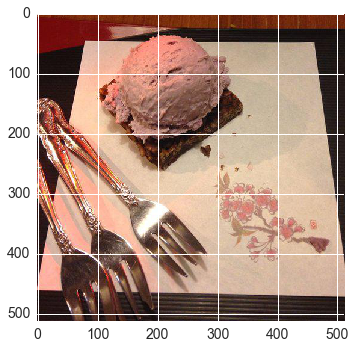

In [15]:
images = list(df[(df['predicted_class'] == 'chocolate_cake') & (df['true_class'] == 'cheesecake')]['label'])
np.random.shuffle(images)
for im in images[:3]:
    image = caffe.io.load_image(os.path.join("../data/food-101/top_classes", im))
    plt.imshow(image)
    plt.show()

***Chocolate cake predicted as cheesecake:***

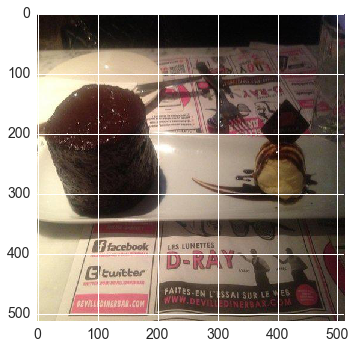

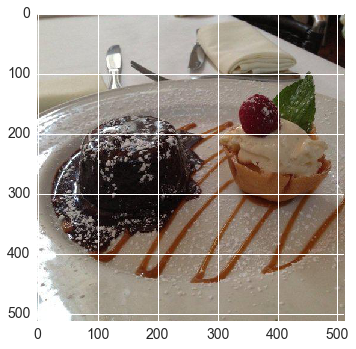

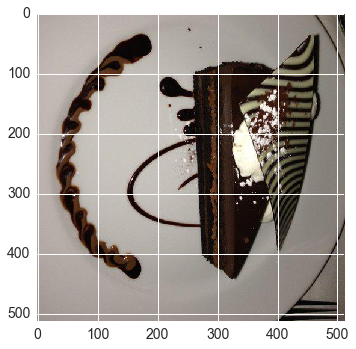

In [16]:
images = list(df[(df['predicted_class'] == 'cheesecake') & (df['true_class'] == 'chocolate_cake')]['label'])
np.random.shuffle(images)
for im in images[:3]:
    image = caffe.io.load_image(os.path.join("../data/food-101/top_classes", im))
    plt.imshow(image)
    plt.show()

To be able to look at Precision-Recall curves for each class, we need predicted probabilities.

The LinearSVC implementation trained on the features does not have a predict_proba method, so we will re-train a SVC with kernel 'linear' using the optimized C value in order to obtain class probabilities

In [17]:
#Load in the saved Linear SVC model
import pickle

with open("../transfer-learning/models/svm_vggnet/svm_vggnet_layer_7_2016_08_17/model.pkl", 'rb') as f:
    clf = pickle.load(f, encoding='latin1') 

In [18]:
from sklearn.svm import SVC

In [19]:
#Get training features and labels
X_train = np.load("../transfer-learning/models/svm_vggnet/svm_vggnet_layer_7_2016_08_17/train_data", encoding='latin1')
X_test = np.load("../transfer-learning/models/svm_vggnet/svm_vggnet_layer_7_2016_08_17/test_data", encoding='latin1')
y_train = np.load("../transfer-learning/models/svm_vggnet/svm_vggnet_layer_7_2016_08_17/train_labels")
y_test = np.load("../transfer-learning/models/svm_vggnet/svm_vggnet_layer_7_2016_08_17/test_labels")

y_train = np.array([x.decode() for x in y_train])
y_test = np.array([x.decode() for x in y_test])

In [23]:
svc = SVC(C=clf.C, kernel='linear', probability=True)

In [24]:
svc.fit(X_train, y_train)

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
predictions = svc.predict(X_test)

In [26]:
#Check that the accuracy and F1 are more or less the same as the results obtained using the LinearSVC
metrics, _, _ = hc.get_metrics(y_test, predictions, class_list)
metrics

,Accuracy,F1,Precision,Recall
Results,0.677,0.677,0.678,0.677


In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [28]:
y_probs = svc.predict_proba(X_test)

In [29]:
precision = dict()
recall = dict()
average_precision = dict()
for i, c in enumerate(svc.classes_):
    t = (y_test == c).astype(int)
    s = y_probs[:, i]
    precision[c], recall[c], _ = precision_recall_curve(t, s)
    average_precision[c] = average_precision_score(t, s)

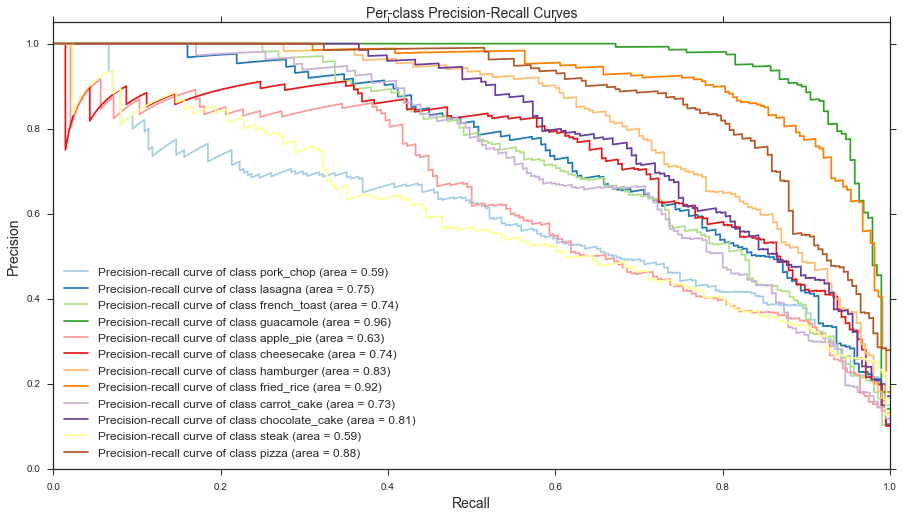

In [30]:
# Plot Precision-Recall curve for each class
colors = ('#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928')
fig, ax = plt.subplots(figsize=(15,8))
ax.set_axis_bgcolor('white')
for cl, co in zip(class_list, colors):
    plt.plot(recall[cl], precision[cl], color=co,
             label='Precision-recall curve of class {} (area = {:.2f})'.format(cl, average_precision[cl]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.title('Per-class Precision-Recall Curves', size=14)
plt.legend(loc="lower left", prop={'size':12})
plt.show()

Finally, look at the accuracy score for top 2 classes:

In [51]:
hc.top_n_class_accuracy(y_probs, svc.classes_, y_test, 2)

0.8475